## Common Information Demo

Author: Cheuk Ting Li  

In [1]:
import numpy
import matplotlib.pyplot as plt
from psitip import *
PsiOpts.setting(solver = "pyomo.glpk")     # Set linear programming solver
PsiOpts.setting(repr_latex = True)         # Turn on Jupyter Notebook LaTeX display
PsiOpts.setting(venn_latex = True)         # Turn on LaTeX in diagrams
PsiOpts.setting(proof_note_color = "blue") # Reasons in proofs are blue
PsiOpts.setting(istorch = True)            # Enable pytorch

X, Y, Z, W, U, M, S = rv("X, Y, Z, W, U, M, S") # Declare random variables

In [2]:
# Gács-Körner common information [Gács-Körner 1973]
# Equivalent characterization using mutual information [Gray-Wyner 1974]
gacs_korner(X & Y) == gacs_korner(X & Y).defn()

gacs_korner(X&Y) == (( ( markov(U, Y, X) )
 &( markov(U, X, Y) ) ).exists(U)).maximum(I(U&X+Y)) 

In [3]:
# Wyner's common information [Wyner 1975]
wyner_ci(X & Y) == wyner_ci(X & Y).defn()

wyner_ci(X&Y) == (( ( markov(X, U, Y) ) ).exists(U)).minimum(I(U&X+Y)) 

In [4]:
# Common entropy [Kumar-Li-El Gamal 2014]
exact_ci(X & Y) == exact_ci(X & Y).defn()

exact_ci(X&Y) == (( ( markov(X, U, Y) ) ).exists(U)).minimum(H(U)) 

------

### Comparisons

In [5]:
# Automatically discover inequalities among quantities
universe().discover([X, Y, 
                     gacs_korner(X & Y), 
                     wyner_ci(X & Y), 
                     exact_ci(X & Y)])

( ( gacs_korner(X&Y) >= 0 )
 &( wyner_ci(X&Y) <= exact_ci(X&Y) )
 &( exact_ci(X&Y) <= H(X) )
 &( exact_ci(X&Y) <= H(Y) )
 &( I(X&Y) <= wyner_ci(X&Y) )
 &( gacs_korner(X&Y) <= I(X&Y) ) )

------

### Alternative Characterization of Gács-Körner Common Information

In [6]:
# Gács-Körner common information [Gács-Körner 1973]
gacs_korner(X & Y, mi = False) == gacs_korner(X & Y, mi = False).defn()

gacs_korner(X&Y) == (( ( H(U|X) == 0 )
 &( H(U|Y) == 0 ) ).exists(U)).maximum(H(U)) 

In [7]:
# Equivalent characterization using mutual information [Gray-Wyner 1974]
gacs_korner(X & Y, mi = True) == gacs_korner(X & Y, mi = True).defn()

gacs_korner_mi(X&Y) == (( ( markov(U, Y, X) )
 &( markov(U, X, Y) ) ).exists(U)).maximum(I(U&X+Y)) 

In [8]:
# Prove equivalence, "<=" direction
(gacs_korner(X & Y, mi = False).defn()
     <= gacs_korner(X & Y, mi = True).defn()).proof()

In [9]:
# To prove the ">=" direction, we need the double Markov property [Csiszar-Korner 2011]
dblmarkov()

(( ( markov(DZ, DX, DY) )
  &( markov(DX, DY, DZ) ) )
>> ( ( H(DW|DX) == 0 )
    &( H(DW|DY) == 0 )
    &( markov(DX+DY, DW, DZ) ) ).exists(DW)).forall(DX+DY+DZ)

In [10]:
# Prove the ">=" direction using double Markov property
with dblmarkov().assumed():
    (gacs_korner(X & Y, mi = False).defn()
         >= gacs_korner(X & Y, mi = True).defn()).proof().display()

<IPython.core.display.Math object>

------

### Data Processing Inequality

In [11]:
r = markov(X, Y, Z)  # X -> Y -> Z forms a Markov chain
(r >> (gacs_korner(X & Y) >= gacs_korner(X & Z))).display_bool()

<IPython.core.display.Math object>

In [12]:
(r >> (wyner_ci(X & Y) >= wyner_ci(X & Z))).display_bool()

<IPython.core.display.Math object>

In [13]:
(r >> (exact_ci(X & Y) >= exact_ci(X & Z))).display_bool()

<IPython.core.display.Math object>

------

### Tensorization / Additivity

In [14]:
r = indep(X + Y, Z + W)  # (X,Y) is independent of (Z,W)

# Gács-Körner common information is additive
(r >> (gacs_korner(X & Y) + gacs_korner(Z & W) >= gacs_korner(X+Z & Y+W))).proof()

In [15]:
(r >> (gacs_korner(X & Y) + gacs_korner(Z & W) <= gacs_korner(X+Z & Y+W))).proof()

In [16]:
# Wyner's common information is additive
(r >> (wyner_ci(X & Y) + wyner_ci(Z & W) >= wyner_ci(X+Z & Y+W))).proof()

In [17]:
(r >> (wyner_ci(X & Y) + wyner_ci(Z & W) <= wyner_ci(X+Z & Y+W))).proof()

In [18]:
# Common entropy is only subadditive
(r >> (exact_ci(X & Y) + exact_ci(Z & W) >= exact_ci(X+Z & Y+W))).proof()

In [19]:
(r >> (exact_ci(X & Y) + exact_ci(Z & W) <= exact_ci(X+Z & Y+W))).solve(display_reg = True)

((  indep(X+Y, Z+W)  )
>> (  exact_ci(X&Y)+exact_ci(Z&W) <= exact_ci(X+Z&Y+W)  )) is Unknown

------

### Condition for Zero

In [20]:
# Gács-Körner = 0 iff X indep. of Y is False
((gacs_korner(X & Y) == 0) == indep(X, Y)).solve(display_reg = True)

(
  (  (  indep(X, Y)  )
  >> (  gacs_korner(X&Y) == 0  ))
 &
  (  (  gacs_korner(X&Y) == 0  )
  >> (  indep(X, Y)  ))
) is Unknown

In [21]:
# Wyner = 0 iff X indep. of Y
((wyner_ci(X & Y) == 0) == indep(X, Y)).solve(display_reg = True)

(
  (  (  indep(X, Y)  )
  >> (  wyner_ci(X&Y) == 0  ))
 &
  (  (  wyner_ci(X&Y) == 0  )
  >> (  indep(X, Y)  ))
) is True
CompArray(
[[U, U_1+X+Y],
 [U, X+Y],
 [U, rv_empty()],
 [U, U_1]])

In [22]:
# Common entropy = 0 iff X indep. of Y
((exact_ci(X & Y) == 0) == indep(X, Y)).solve(display_reg = True)

(
  (  (  indep(X, Y)  )
  >> (  exact_ci(X&Y) == 0  ))
 &
  (  (  exact_ci(X&Y) == 0  )
  >> (  indep(X, Y)  ))
) is True
CompArray(
[[U, U_1+X+Y],
 [U, X+Y],
 [U, rv_empty()],
 [U, U_1]])

------

### Perfectly Resolvable Case

In [23]:
# X, Y are perfectly resolvable with common part W [Prabhakaran-Prabhakaran 2014]
r = (H(W | X) == 0) & (H(W | Y) == 0) & markov(X, W, Y)

In [24]:
# If perfectly resolvable, then Gács-Körner = H(W)
(r >> (gacs_korner(X & Y) == H(W))).solve(display_reg = True)

(( ( H(W|X) == 0 )
  &( H(W|Y) == 0 )
  &( markov(X, W, Y) ) )
>> (  gacs_korner(X&Y) == H(W)  )) is True
CompArray(
[[U, U_1+W]])

In [25]:
# If perfectly resolvable, then Wyner = H(W)
(r >> (wyner_ci(X & Y) == H(W))).solve(display_reg = True)

(( ( H(W|X) == 0 )
  &( H(W|Y) == 0 )
  &( markov(X, W, Y) ) )
>> (  wyner_ci(X&Y) == H(W)  )) is True
CompArray(
[[U, W]])

In [26]:
# If perfectly resolvable, then Common entropy = H(W)
(r >> (exact_ci(X & Y) == H(W))).solve(display_reg = True)

(( ( H(W|X) == 0 )
  &( H(W|Y) == 0 )
  &( markov(X, W, Y) ) )
>> (  exact_ci(X&Y) == H(W)  )) is True
CompArray(
[[U, W]])

------

### Numerical Evaluation for Binary Symmetric Source

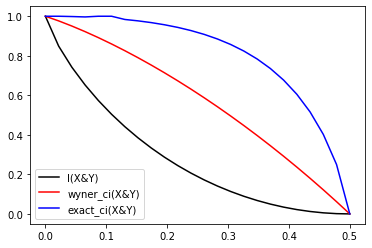

In [27]:
# Switch to basin-hopping for nonconvex optimization
# PsiOpts.setting(opt_basinhopping = True)

# PsiOpts.setting(opt_aux_card = 2)    # Default cardinality for auxiliary
# PsiOpts.setting(opt_num_points = 24) # Number of initial points to try
# PsiOpts.setting(opt_num_hop = 4)     # Number of hops
# PsiOpts.setting(opt_num_iter = 8)    # Number of iterations per hop

X, Y = rv("X, Y").set_card(2)     # X,Y are binary RVs (cardinality = 2)
P = ConcModel()                   # Underlying distribution of RVs
P[X] = [0.5, 0.5]                 # X is a fair bit

ts = numpy.linspace(0.0, 0.5, 24)
ms, js, gs = [], [], []
for t in ts:
    P[Y | X] = [[1-t, t], [t, 1-t]]  # P(Y|X) is BSC(t)
    ms.append(P[I(X & Y)])           # Evaluate mutual information
    js.append(P[wyner_ci(X & Y)])    # Wyner's common information
    gs.append(P[exact_ci(X & Y)])    # Common entropy

# Plot the quantities against t
plt.figure()
plt.plot(ts, ms, 'k', label = str(I(X & Y)))
plt.plot(ts, js, 'r', label = str(wyner_ci(X & Y)))
plt.plot(ts, gs, 'b', label = str(exact_ci(X & Y)))
plt.legend()
plt.show()

### References
- P. Gács and J. Körner, "Common information is far less than mutual information," Problems Control Inf. Theory, vol. 2, no. 2, pp. 149–162, 1973.
- A. D. Wyner, "The common information of two dependent random variables," IEEE Trans. Inf. Theory, vol. IT-21, no. 2, pp. 163-179, Mar. 1975.
- G. R. Kumar, C. T. Li, and A. El Gamal, "Exact common information," in Proc. IEEE Symp. Info. Theory. IEEE, 2014, pp. 161-165.
- R. M. Gray and A. D. Wyner, "Source coding for a simple network," Bell Syst. Tech. J., vol. 53, no. 9, pp. 1681–1721, 1974.
- I. Csiszár and J. Körner, "Information theory: coding theorems for discrete memoryless systems," Cambridge University Press, 2011.
- C. T. Li and A. El Gamal, "Extended Gray–Wyner system with complementary causal side information," IEEE Trans. Inf. Theory, vol. 64, no. 8, pp. 5862–5878, 2017
- V. M. Prabhakaran and M. M. Prabhakaran, "Assisted common information with an application to secure two-party sampling," IEEE Transactions on Information Theory, vol. 60, no. 6, pp. 3413-3434, 2014.
